<a href="https://colab.research.google.com/github/NandiniLReddy/SAMvsEfficientSAM/blob/main/EfficientSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effcient-SAM deployed by Nandini Lokesh Reddy

# EFFICIENT SAM

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
import cv2
GRID_SIZE = 32

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fer4994l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fer4994l
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
!git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("EfficientSAM")

fatal: destination path 'EfficientSAM' already exists and is not an empty directory.


In [ ]:
from segment_anything.utils.amg import (
    batched_mask_to_box,
    calculate_stability_score,
    mask_to_rle_pytorch,
    remove_small_regions,
    rle_to_mask,
)
from torchvision.ops.boxes import batched_nms, box_area
def process_small_region(rles):
        new_masks = []
        scores = []
        min_area = 100
        nms_thresh = 0.7
        for rle in rles:
            mask = rle_to_mask(rle[0])

            mask, changed = remove_small_regions(mask, min_area, mode="holes")
            unchanged = not changed
            mask, changed = remove_small_regions(mask, min_area, mode="islands")
            unchanged = unchanged and not changed

            new_masks.append(torch.as_tensor(mask).unsqueeze(0))
            # Give score=0 to changed masks and score=1 to unchanged masks
            # so NMS will prefer ones that didn't need postprocessing
            scores.append(float(unchanged))

        # Recalculate boxes and remove any new duplicates
        masks = torch.cat(new_masks, dim=0)
        boxes = batched_mask_to_box(masks)
        keep_by_nms = batched_nms(
            boxes.float(),
            torch.as_tensor(scores),
            torch.zeros_like(boxes[:, 0]),  # categories
            iou_threshold=nms_thresh,
        )

        # Only recalculate RLEs for masks that have changed
        for i_mask in keep_by_nms:
            if scores[i_mask] == 0.0:
                mask_torch = masks[i_mask].unsqueeze(0)
                rles[i_mask] = mask_to_rle_pytorch(mask_torch)
        masks = [rle_to_mask(rles[i][0]) for i in keep_by_nms]
        return masks

In [ ]:
def get_predictions_given_embeddings_and_queries(img, points, point_labels, model):
    predicted_masks, predicted_iou = model(
        img[None, ...], points, point_labels
    )
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou_scores = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_masks = torch.take_along_dim(
        predicted_masks, sorted_ids[..., None, None], dim=2
    )
    predicted_masks = predicted_masks[0]
    iou = predicted_iou_scores[0, :, 0]
    index_iou = iou > 0.7
    iou_ = iou[index_iou]
    masks = predicted_masks[index_iou]
    score = calculate_stability_score(masks, 0.0, 1.0)
    score = score[:, 0]
    index = score > 0.9
    score_ = score[index]
    masks = masks[index]
    iou_ = iou_[index]
    masks = torch.ge(masks, 0.0)
    return masks, iou_

def run_everything_ours(img_path, model):
    model = model.cpu()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = ToTensor()(image)
    _, original_image_h, original_image_w = img_tensor.shape
    xy = []
    for i in range(GRID_SIZE):
        curr_x = 0.5 + i / GRID_SIZE * original_image_w
        for j in range(GRID_SIZE):
            curr_y = 0.5 + j / GRID_SIZE * original_image_h
            xy.append([curr_x, curr_y])
    xy = torch.from_numpy(np.array(xy))
    points = xy
    num_pts = xy.shape[0]
    point_labels = torch.ones(num_pts, 1)
    with torch.no_grad():
      predicted_masks, predicted_iou = get_predictions_given_embeddings_and_queries(
              img_tensor.cpu(),
              points.reshape(1, num_pts, 1, 2).cpu(),
              point_labels.reshape(1, num_pts, 1).cpu(),
              model.cpu(),
          )
    rle = [mask_to_rle_pytorch(m[0:1]) for m in predicted_masks]
    predicted_masks = process_small_region(rle)
    return predicted_masks

In [ ]:
def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask[0].shape[0], mask[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in mask:
        m = ann
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vits
import zipfile

with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")
efficient_sam_vits_model = build_efficient_sam_vits()
efficient_sam_vits_model.eval()

EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
        )
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    

THIS IS THE IMAGE LINK: https://cdn.mos.cms.futurecdn.net/ASHH5bDmsp6wnK6mEfZdcU-1200-80.jpg

(-0.5, 1199.5, 674.5, -0.5)

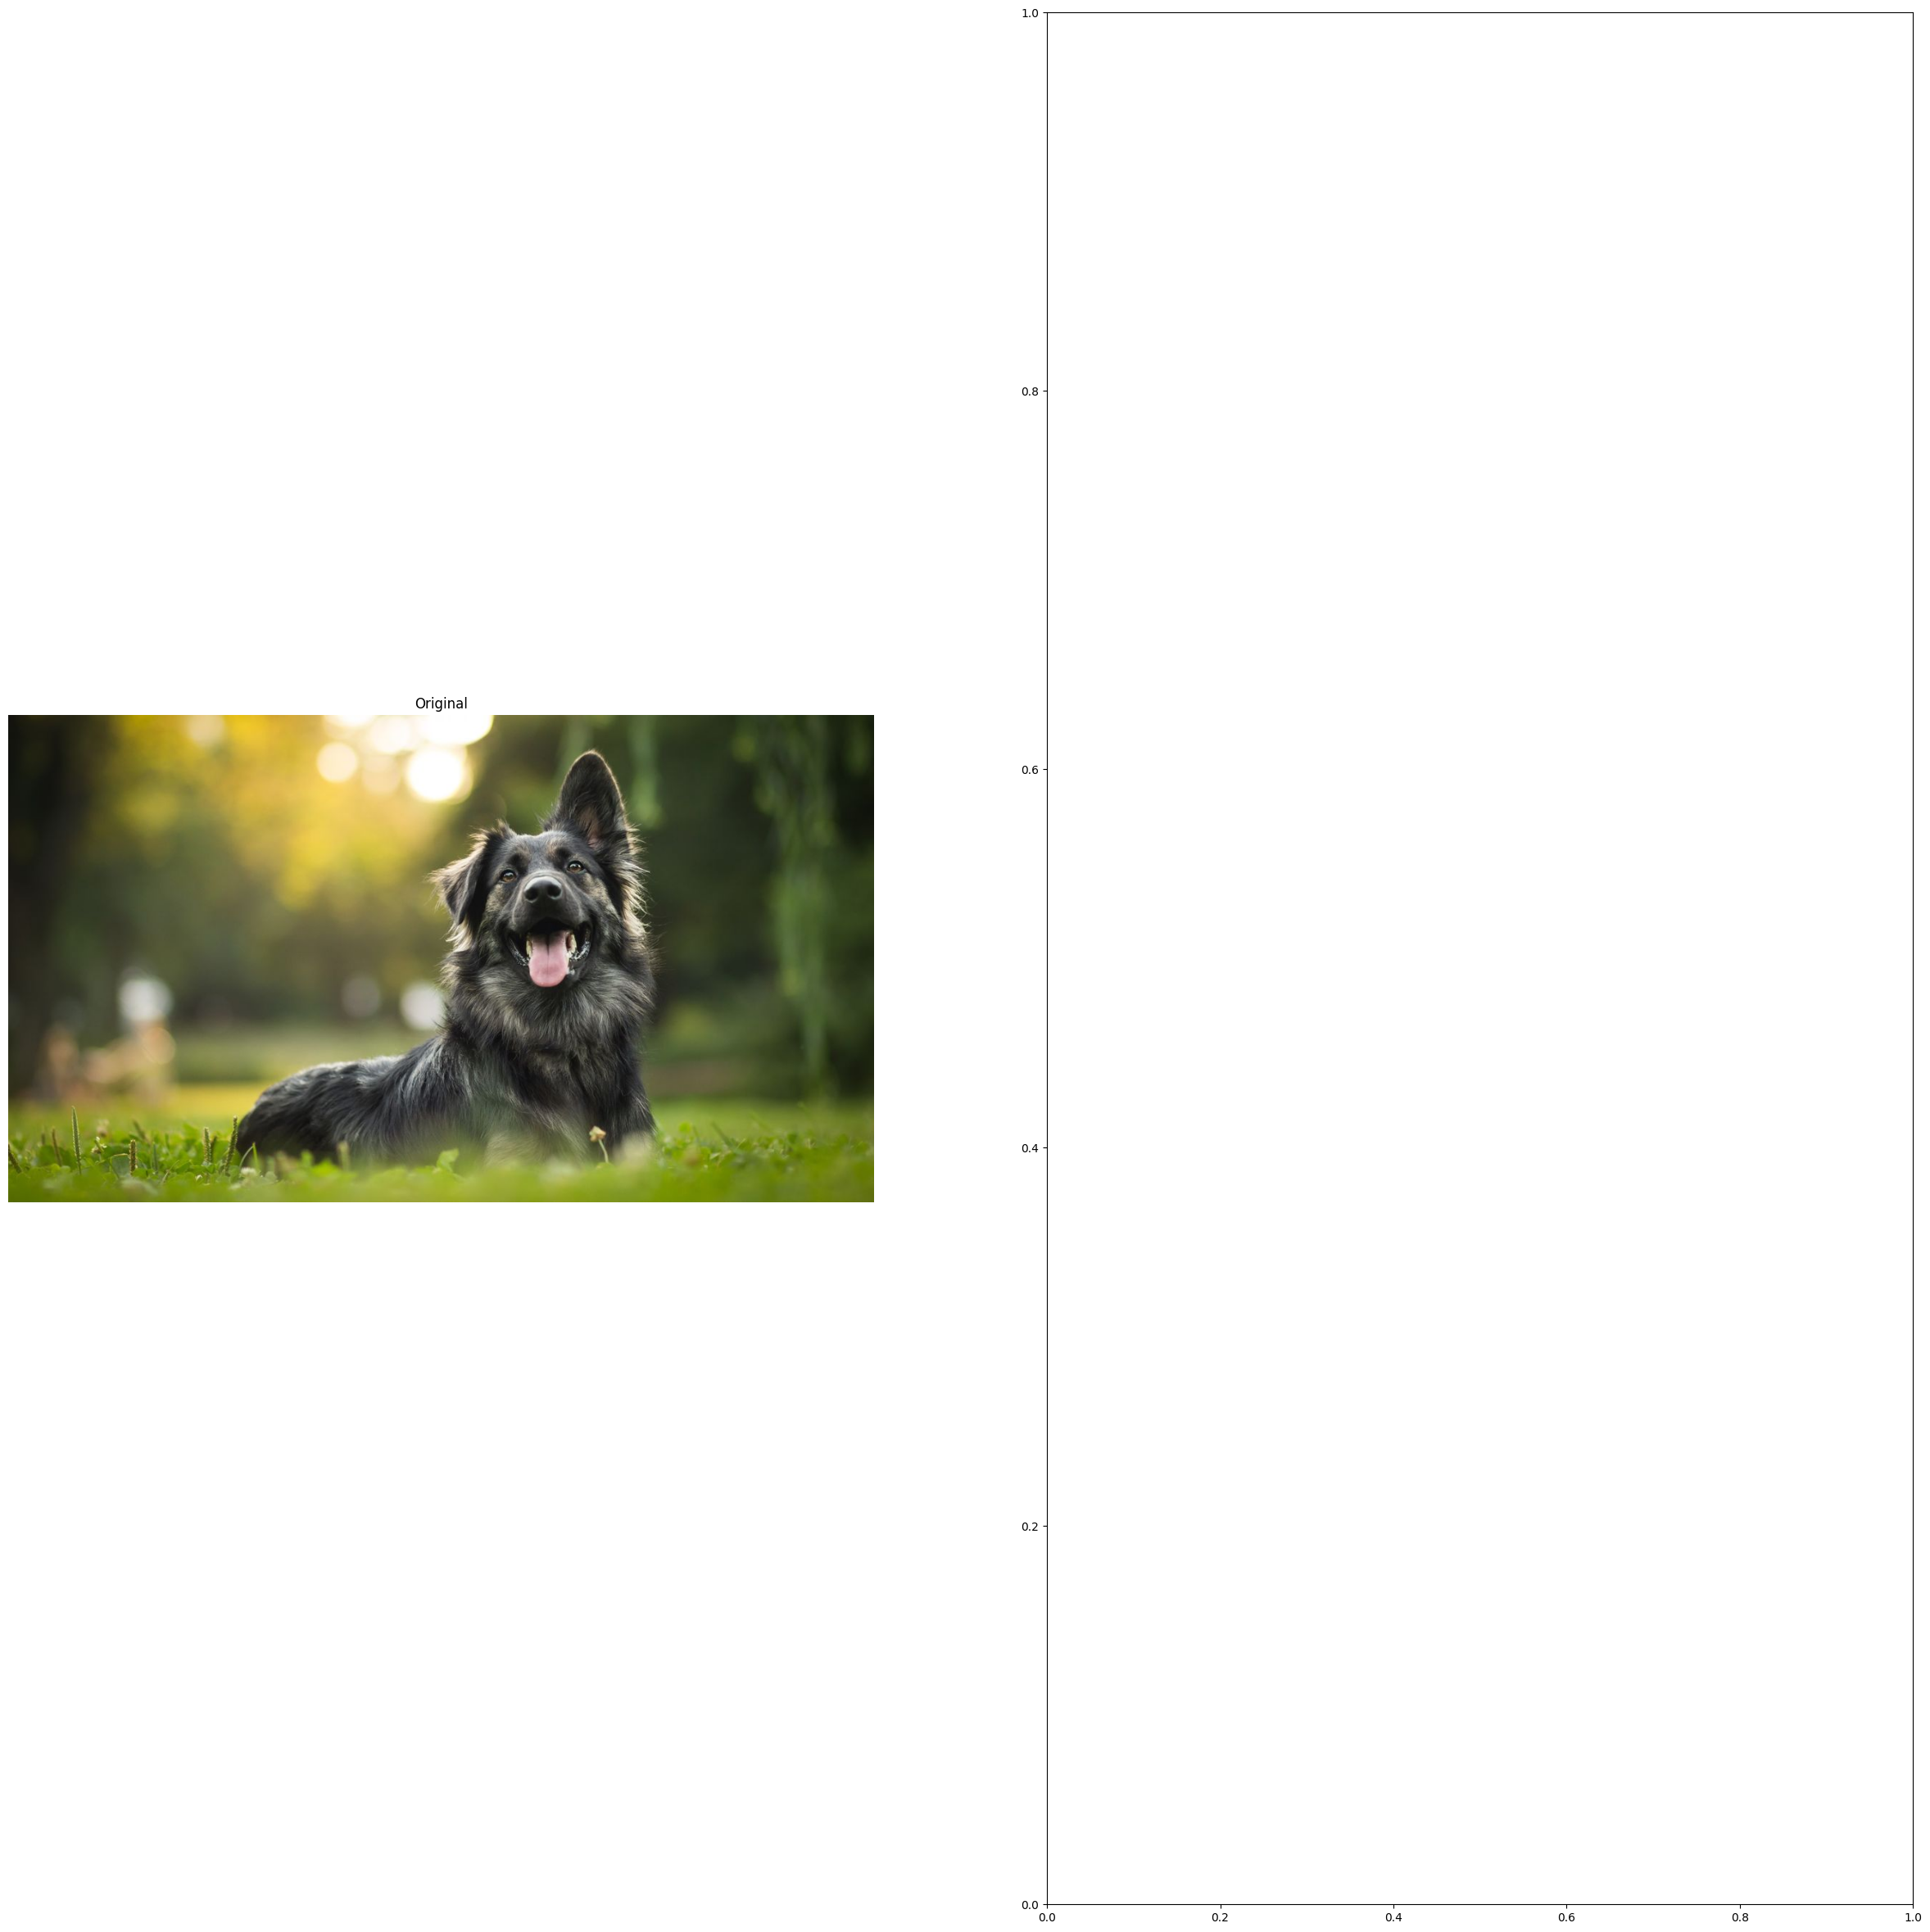

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 30))
image_path = "/content/images/dog2.jpg"
image = np.array(Image.open(image_path))
ax[0].imshow(image)
ax[0].title.set_text("Original")
ax[0].axis('off')
ax[1].imshow(image)
mask_efficient_sam_vits = run_everything_ours(image_path, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[1])
ax[1].title.set_text("EfficientSAM")
ax[1].axis('off')


plt.show()

# SAM

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5m6wj75l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5m6wj75l
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=0ae98ef5cf80278bd79dd2b180709777c0af068f4044d2ae5f8355a21fa27700
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzc1y082/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
%cd {HOME}
!mkdir {HOME}/weights

%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import cv2


image_bgr = cv2.imread("/content/dog2.jpg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [ ]:
!pip install supervision --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 4.2 MB/s eta 0:00:00


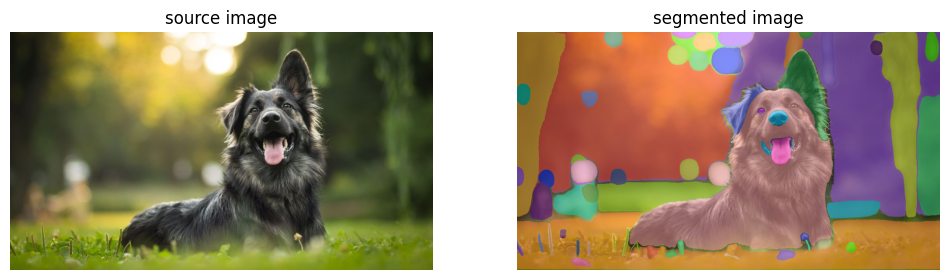

In [ ]:
import supervision as sv
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)